## Setup Installation

In [1]:
!pip install nltk
!pip install scikit-learn
!pip install tensorflow
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 4.0 MB/s eta 0:00:00


## Import Libraries

In [2]:
# Standard library imports
import os
import sys
from collections import Counter
from tempfile import NamedTemporaryFile
from urllib.parse import urlparse, unquote
from urllib.request import urlopen
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# Third-party imports for data manipulation and analysis
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Third-party imports for natural language processing
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import TextVectorization

# Third-party imports for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras_tuner
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.metrics import Precision, Recall

# Third-party imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Google Colab specific import
from google.colab import drive

<ipython-input-2-dc6db0347af0>:40: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


## Import & Load Datasets

In [3]:
#Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [9]:
path = '/content/drive/My Drive/Colab Notebooks/look-before-you-leap/'

In [89]:
# Load the URL dataset
df_url = pd.read_excel(path+'URL.xlsx')

# Load the HTML dataset
df_html = pd.read_excel(path+'html.xlsx')

print(df_url.head())
print(df_html.head())

  Category  \
0     spam   
1     spam   
2     spam   
3     spam   
4     spam   

                                                                                 Data  
0                       logtelstra2021.ddnsking.com/0dfa1b53b835500696e9a1f02cd1f464/  
1  dvsber.ru/modules/mod_ariimageslidersa/KRENK3N453/e2d9ebfbc01e29f3061836c0dd7ce5dd  
2                     kimsinc564.000webhostapp.com/notification.php?email=[[-Email-]]  
3                                                                      benjim.com/all  
4                                                     www.m.micesrunescape.com-we.ru/  
  Category  \
0     spam   
1     spam   
2     spam   
3     spam   
4     spam   

                                                                                                                                                                                                                                                                                                              

## EDA

In [90]:
df_url.info()
df_html.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45373 entries, 0 to 45372
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  45373 non-null  object
 1   Data      45373 non-null  object
dtypes: object(2)
memory usage: 709.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45373 entries, 0 to 45372
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  45373 non-null  object
 1   Data      45373 non-null  object
dtypes: object(2)
memory usage: 709.1+ KB


In [91]:
# Validate duplicate rows

duplicate_rows_url = df_url[df_url.duplicated(subset='Data')]
duplicate_rows_html = df_html[df_html.duplicated(subset='Data')]

if not duplicate_rows.empty:
    print('Found Duplicate Rows: ')
    print(duplicate_rows)
else:
    print('Duplicate rows not found.')

Found Duplicate Rows: 
      Category  \
662       spam   
820       spam   
1900      spam   
2211      spam   
2660      spam   
...        ...   
45307     spam   
45320     spam   
45332     spam   
45340     spam   
45370     spam   

                                                                                                                                               Data  
662                                                                                                                 www.m.micesrunescape.com-we.ru/  
820                                                                                                                                      rabot.dev/  
1900                                                                               eagle10.firebaseapp.com/wp-content/plugins/apple/456753861a4e779  
2211                                                                                                                  servlces.runescape.com-ov.ru/  
2660      

In [92]:
df_url.head()
df_html.head()

Category  \
0     spam   
1     spam   
2     spam   
3     spam   
4     spam   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [93]:
#Value URL Counts
count_url_spam = df_url['Category'].value_counts()['spam']
count_url_ham = df_url['Category'].value_counts()['ham']


print('Total URL spam: ', count_url_spam)
print('Total URL ham: ', count_url_spam)

print('Total rows:', df_url.shape[0])

Total URL spam:  22686
Total URL ham:  22686
Total rows: 45373


In [94]:
#Value HTLM Counts
count_html_spam = df_html['Category'].value_counts()['spam']
count_html_ham = df_html['Category'].value_counts()['ham']


print('Total HTML spam: ', count_html_spam)
print('Total HTML ham: ', count_html_ham)

print('Total rows:', df_html.shape[0])

Total URL spam:  22686
Total URL ham:  22687
Total rows: 45373


In [95]:
# Validate missing values

print("\nMissing Values on URL:")
print(df_url.isnull().sum())
print("\nMissing Values on HTML:")
print(df_html.isnull().sum())


Missing Values on URL:
Category    0
Data        0
dtype: int64

Missing Values on HTML:
Category    0
Data        0
dtype: int64


### Data Visualization

<ipython-input-96-cf989cbdc92e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=df_html, palette=color_palette, ax=axes[0])
<ipython-input-96-cf989cbdc92e>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=df_url, palette=color_palette, ax=axes[1])


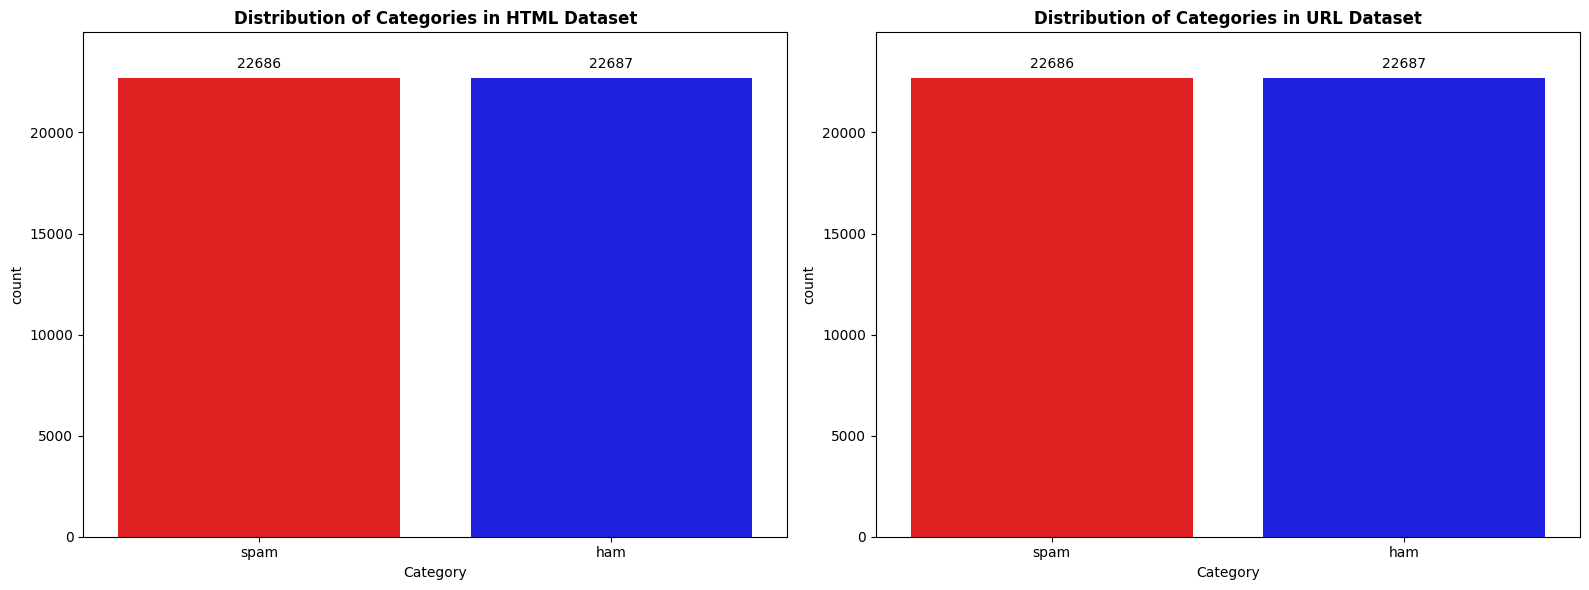

In [96]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Customized color palette
color_palette = ['red', 'blue']

# Plot for HTML dataset
sns.countplot(x='Category', data=df_html, palette=color_palette, ax=axes[0])
axes[0].set_title('Distribution of Categories in HTML Dataset', fontweight='bold')

# Add exact values on top of the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

axes[0].set_ylim(0, max([p.get_height() for p in axes[0].patches])*1.1)

# Plot for URL dataset
sns.countplot(x='Category', data=df_url, palette=color_palette, ax=axes[1])
axes[1].set_title('Distribution of Categories in URL Dataset', fontweight='bold')

# Add exact values on top of the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

axes[1].set_ylim(0, max([p.get_height() for p in axes[1].patches])*1.1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

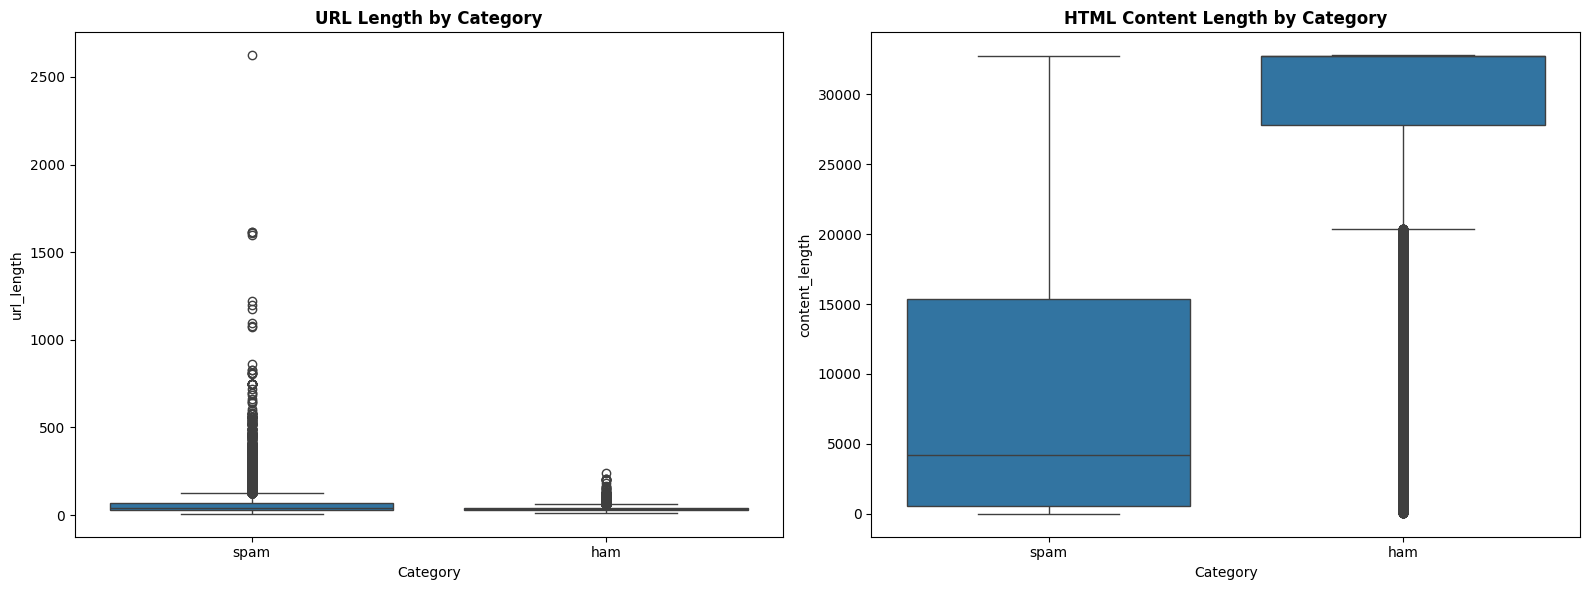

In [97]:
# URL Length Analysis
df_url['url_length'] = df_url['Data'].apply(len)

# HTML Content Length Analysis
df_html['content_length'] = df_html['Data'].apply(len)

plt.figure(figsize=(16, 6))

# URL Length Analysis
plt.subplot(1, 2, 1)
sns.boxplot(x='Category', y='url_length', data=df_url)
plt.title('URL Length by Category', fontweight="bold")

# HTML Content Length Analysis
plt.subplot(1, 2, 2)
sns.boxplot(x='Category', y='content_length', data=df_html)
plt.title('HTML Content Length by Category', fontweight="bold")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


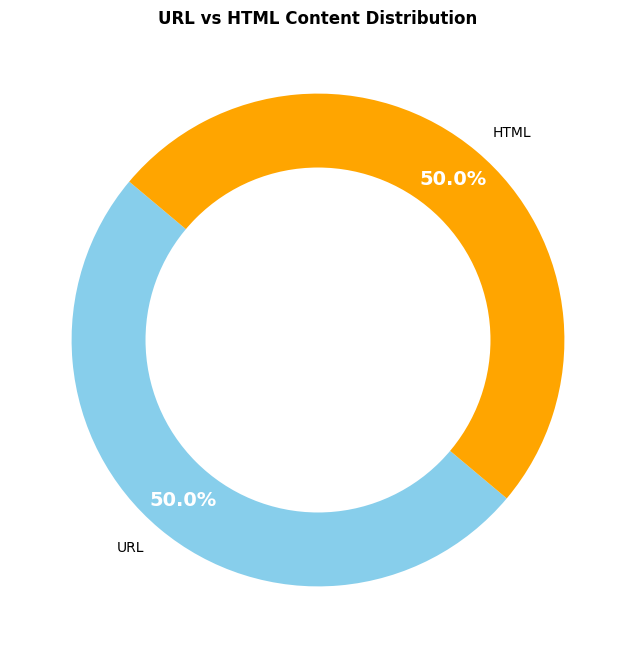

In [98]:
# Calculate Presentege

# Calculate the total number of entries
total_entries = len(df_url) + len(df_html)

# Calculate percentages
url_percentage = (len(df_url) / total_entries) * 100
html_percentage = (len(df_html) / total_entries) * 100

# Visualize URL and HTML Content Distribution as a Donut Chart
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['skyblue', 'orange']  # Skyblue for URL, Orange for HTML
content_distribution = [url_percentage, html_percentage]
wedges, texts, autotexts = ax.pie(content_distribution, labels=['URL', 'HTML'], autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)

# Draw a white circle at the center to create a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Customize the font size and color of the percentage labels
plt.setp(autotexts, size=14, weight="bold", color="white")

# Add a title to the plot
plt.title('URL vs HTML Content Distribution', fontweight='bold')

# Show the plot
plt.show()

## Preprocessing Data

In [99]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [100]:
# Load stopwords once to improve efficiency
STOPWORDS = set(stopwords.words('english'))

In [101]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [102]:
# Function to clean and preprocess URL data
def preprocess_url(url):
    url = url.lower()  # Convert to lowercase
    url = re.sub(r'https?://', '', url)  # Remove http or https
    url = re.sub(r'www\.', '', url)  # Remove www
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)  # Remove special characters
    url = re.sub(r'\s+', ' ', url).strip()  # Remove extra spaces
    tokens = word_tokenize(url)  # Tokenize
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

In [103]:
# Function to clean and preprocess HTML data
def preprocess_html(html):
    html = re.sub(r'<[^>]+>', ' ', html)  # Remove HTML tags
    html = html.lower()  # Convert to lowercase
    html = re.sub(r'https?://', '', html)  # Remove http or https
    html = re.sub(r'[^a-zA-Z0-9]', ' ', html)  # Remove special characters
    html = re.sub(r'\s+', ' ', html).strip()  # Remove extra spaces
    tokens = word_tokenize(html)  # Tokenize
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

In [104]:
# Clean URL 'Data' Columns
df_url['Cleaned_Data'] = df_url['Data'].apply(preprocess_url)

In [105]:
# URL Data After Cleaning
print("URL Data After Cleaning:")
display(df_url[['Data', 'Cleaned_Data']].head())

URL Data After Cleaning:


,Data,Cleaned_Data
0,logtelstra2021.ddnsking.com/0dfa1b53b835500696e9a1f02cd1f464/,logtelstra2021 ddnsking com 0dfa1b53b835500696e9a1f02cd1f464
1,dvsber.ru/modules/mod_ariimageslidersa/KRENK3N453/e2d9ebfbc01e29f3061836c0dd7ce5dd,dvsber ru module mod ariimageslidersa krenk3n453 e2d9ebfbc01e29f3061836c0dd7ce5dd
2,kimsinc564.000webhostapp.com/notification.php?email=[[-Email-]],kimsinc564 000webhostapp com notification php email email
3,benjim.com/all,benjim com
4,www.m.micesrunescape.com-we.ru/,micesrunescape com ru


In [106]:
# Clean HTML 'Data' Columns
df_html['Cleaned_Data'] = df_html['Data'].apply(preprocess_html)

In [107]:
# HTML Data After Cleaning
print("\nHTML Data After Cleaning:")
display(df_html[['Data', 'Cleaned_Data']].head())


HTML Data After Cleaning:


Data  \
0                                                    <!DOCTYPE html>', '', '<html>', '<head>', '<meta charset="utf-8"/>', '<title> Send Money, Pay Online or Set Up a Merchant Account - PayPal  </title>', '<meta content="width=device-width, initial-scale=1.0" name="viewport"/>', '<meta content="" id="metadesc" name="description"/>', '<script type="text/javascript">', '$(document).ready(function(){', 'var startdesc = "Hi Spammer this Scam was Created by DemonBlade, To contact Me on email : wixamino@gmail.com";', '$("#metadesc").attr("content",startdesc);', '});', '</script>', '<script charset="utf-8" src="js/ajax.js"></script>', '<script charset="utf-8" src="js/jquery.js"></script>', '<script charset="utf-8" src="js/jquery.min.js"></script>', '<script charset="utf-8" src="js/js-plus.js"></script>', '<link href="css/styles.css" rel="stylesheet"/>', '<link href="https://www.paypalobjects.com/en_US/i/icon/pp_favicon_x.ico" rel="shortcut icon"/>', '<link href="https://file.myfontastic.com/hSMyDca9BDwBA8GgvxRZRP/icons.css" rel="stylesheet"/>', '</head>', '<body>', '<div class="get_contents">', '<!DOCTYPE doctype html>', '', '<html class="no-js" data-device-type="dedicated" lang="de-DE"><head><meta charset="utf-8"><title>Bargeldloses Bezahlen - Online Shopping | PayPal DE</title><meta content="PayPal, online kaufen, einkaufen, verkaufen, bezahlen, Geld verdienen, Sicherheit, sicher bezahlen, käuferschutz" name="keywords"><meta content="Mit PayPal einfach und sicher bargeldlos bezahlen, Zahlungen empfangen &amp; Geld senden. Profitieren auch Sie vom Käuferschutz &amp; Verkäuferschutz." name="description"><meta content="NOODP" name="robots"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="PayPal" name="application-name"/><meta content="name=My Account;action-uri=\'https://www.paypal.com/de/cgi-bin/webscr?cmd=_account;icon-uri=https://www.paypalobjects.com/webstatic/icon/favicon.ico" name="msapplication-task"/><meta content="name=Send Money;action-uri=https://www.paypal.com/de/webapps/mpp/send-money-online;icon-uri=https://www.paypalobjects.com/webstatic/icon/favicon.ico" name="msapplication-task"/><meta content="name=Request Money;action-uri=https://www.paypal.com/de/webapps/mpp/requesting-payments;icon-uri=https://www.paypalobjects.com/webstatic/icon/favicon.ico" name="msapplication-task"/><meta content="width=device-width, initial-scale=1.0" name="viewport"/><link href="https://www.paypal.com/de/home" rel="canonical"><link as="font" href="https://www.paypalobjects.com/digitalassets/c/paypal-ui/fonts/PayPalSansSmall-Regular.woff2" rel="preload" type="font/woff2"><link as="font" href="https://www.paypalobjects.com/digitalassets/c/paypal-ui/fonts/PayPalSansBig-Light.woff2" rel="preload" type="font/woff2"><link href="https://www.paypalobjects.com/webstatic/icon/pp144.png" rel="apple-touch-icon" sizes="144x144"/><link href="https://www.paypalobjects.com/webstatic/icon/pp114.png" rel="apple-touch-icon" sizes="114x114"/><link href="https://www.paypalobjects.com/webstatic/icon/pp72.png" rel="apple-touch-icon" sizes="72x72"/><link href="https://www.paypalobjects.com/webstatic/icon/pp64.png" rel="apple-touch-icon"/><link href="https://www.paypalobjects.com/webstatic/icon/pp196.png" rel="shortcut icon" sizes="196x196"/><link href="https://www.paypalobjects.com/webstatic/icon/favicon.ico" rel="shortcut icon" type="image/x-icon"/><link href="https://www.paypalobjects.com/webstatic/icon/pp32.png" rel="icon" type="image/x-icon"/><link href="https://www.paypalobjects.com" rel="dns-prefetch"/><script nonce="Vm4S1kJbuhztMH3s0azr3yBmsHMCRvY0gRD1beIMjfjcG5Kh" type="application/ld+json">{"@context": "http://schema.org/","@type": "Organization","url": "https://www.paypal.com/","logo": "https://www.paypalobjects.com/webstatic/i/logo/rebrand/ppcom.png"}</script><style id="antiClickjack">html.js body {display: none !important;}</style><script nonce="Vm4S1kJbuhztMH3s0azr3yBmsHMCRvY0gRD1beIMjfjcG5Kh">if (self === top || /paypal.com$

In [108]:
# Define the maximum length of sequences
max_url_length = 180
max_html_length = 2000

# Define the maximum number of words/tokens
max_words = 10000

### URL & HTML Tokenizing and Padding

In [109]:
url_tokenizer = Tokenizer(num_words=max_words, char_level=True)
url_tokenizer.fit_on_texts(df_url['Cleaned_Data'])
url_sequences = url_tokenizer.texts_to_sequences(df_url['Cleaned_Data'])
url_padded = pad_sequences(url_sequences, maxlen=max_url_length, padding='post', truncating='post')

In [110]:
html_tokenizer = Tokenizer(num_words=max_words)
html_tokenizer.fit_on_texts(df_html['Cleaned_Data'])
html_sequences = html_tokenizer.texts_to_sequences(df_html['Cleaned_Data'])
html_padded = pad_sequences(html_sequences, maxlen=max_html_length, padding='post', truncating='post')

In [112]:
# Encode 'Category' column
label_encoder = LabelEncoder()
df_url['Category_Encoded'] = label_encoder.fit_transform(df_url['Category'])
df_html['Category_Encoded'] = label_encoder.transform(df_html['Category'])

### Split Dataset

In [113]:
url_X_train, url_X_test, url_y_train, url_y_test = train_test_split(url_padded, df_url['Category_Encoded'], test_size=0.2, random_state=42)
html_X_train, html_X_test, html_y_train, html_y_test = train_test_split(html_padded, df_html['Category_Encoded'], test_size=0.2, random_state=42)

## Build Model

- Architcture Model

In [114]:
def create_model():
    # Adjusted hyperparameters
    embedding_dim = 16  # Increased embedding dimension
    conv_filters = 64  # Increased number of filters in convolutional layers
    kernel_size = 10 # Increased kernel size
    dense_units_1 = 64
    dense_units_2 = 32
    learning_rate = 0.0005  # Adjusted learning rate

    # Model architecture
    url_input = layers.Input(shape=(max_url_length,), name='url_input')
    url_embedding = layers.Embedding(input_dim=min(max_words, len(url_tokenizer.word_index) + 1),
                                     output_dim=embedding_dim, input_length=max_url_length, name='url_embedding')(url_input)
    url_conv = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(url_embedding)
    url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
    url_flat = layers.Flatten()(url_pool)

    html_input = layers.Input(shape=(max_html_length,), name='html_input')
    html_embedding = layers.Embedding(input_dim=min(max_words, len(html_tokenizer.word_index) + 1),
                                      output_dim=embedding_dim, input_length=max_html_length, name='html_embedding')(html_input)
    html_conv = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(html_embedding)
    html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
    html_flat = layers.Flatten()(html_pool)

    concatenated = layers.Concatenate(name='concatenate_layer')([url_flat, html_flat])
    dense1 = layers.Dense(dense_units_1, activation='relu', name='dense1')(concatenated)
    dense2 = layers.Dense(dense_units_2, activation='relu', name='dense2')(dense1)
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(dense2)

    # Model compilation with directly imported metrics
    model = models.Model(inputs=[url_input, html_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model

In [115]:
# Create the model
model = create_model()

In [116]:
# Model Summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 url_input (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 html_input (InputLayer)     [(None, 2000)]               0         []                            
                                                                                                  
 url_embedding (Embedding)   (None, 180, 16)              608       ['url_input[0][0]']           
                                                                                                  
 html_embedding (Embedding)  (None, 2000, 16)             160000    ['html_input[0][0]']          
                                                                                            

## Training Model

In [117]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [118]:
# Model Training
history = model.fit(
    [url_X_train, html_X_train],  # URL and HTML training data
    url_y_train,
    validation_data=([url_X_test, html_X_test], url_y_test),  # URL and HTML validation data
    epochs=30,  # Number of epochs to train for
    batch_size=8,  # Batch size for training
    callbacks=[early_stopping]  # Early stopping callback
)

Epoch 1/30
4538/4538 [==============================] - 287s 62ms/step - loss: 0.1446 - accuracy: 0.9446 - precision_1: 0.9460 - recall_1: 0.9432 - val_loss: 0.0876 - val_accuracy: 0.9699 - val_precision_1: 0.9711 - val_recall_1: 0.9683
Epoch 2/30
4538/4538 [==============================] - 71s 16ms/step - loss: 0.0501 - accuracy: 0.9829 - precision_1: 0.9837 - recall_1: 0.9821 - val_loss: 0.0914 - val_accuracy: 0.9684 - val_precision_1: 0.9507 - val_recall_1: 0.9876
Epoch 3/30
4538/4538 [==============================] - 58s 13ms/step - loss: 0.0247 - accuracy: 0.9918 - precision_1: 0.9922 - recall_1: 0.9914 - val_loss: 0.0952 - val_accuracy: 0.9732 - val_precision_1: 0.9783 - val_recall_1: 0.9676
Epoch 4/30
4538/4538 [==============================] - 50s 11ms/step - loss: 0.0146 - accuracy: 0.9956 - precision_1: 0.9952 - recall_1: 0.9961 - val_loss: 0.1209 - val_accuracy: 0.9736 - val_precision_1: 0.9747 - val_recall_1: 0.9721


## Model Evaluation

In [119]:
y_pred_prob = model.predict([url_X_test, html_X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

284/284 [==============================] - 1s 3ms/step


In [120]:
# Calculating metrics
accuracy = accuracy_score(url_y_test, y_pred)
precision = precision_score(url_y_test, y_pred)
recall = recall_score(url_y_test, y_pred)
f1 = f1_score(url_y_test, y_pred)

In [121]:
# Printing evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9699
Precision: 0.9711
Recall: 0.9683
F1 Score: 0.9697


# Training & Validation Loss and Accuracy

In [122]:
# Extracting values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Epochs range
epochs_range = range(1, len(training_loss) + 1)

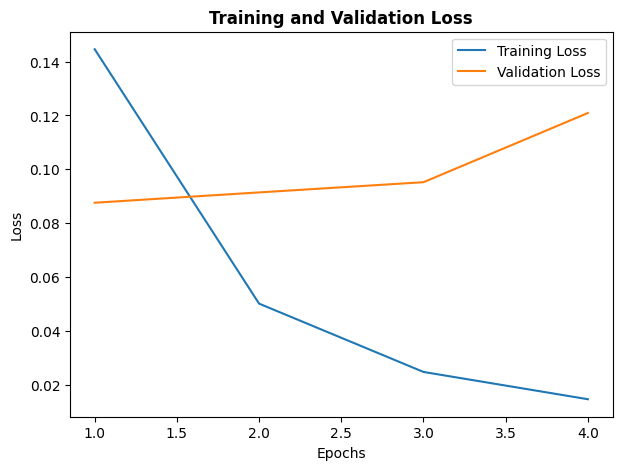

In [123]:
# Plotting Training and Validation Loss
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')  # Save the figure as an image
plt.show()

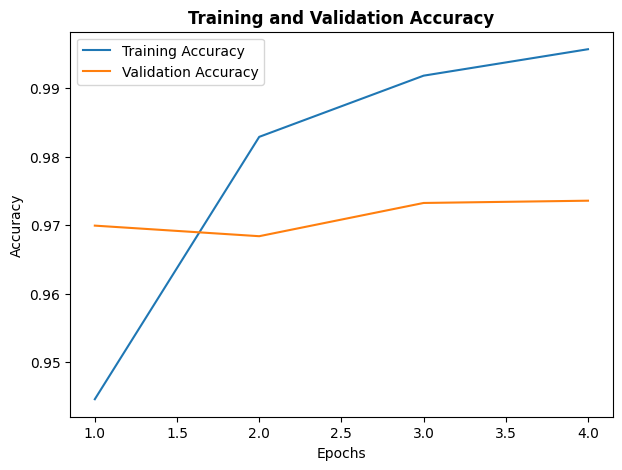

In [124]:
# Plotting Training and Validation Accuracy
plt.figure(figsize=(7, 5))
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # Save the figure as an image
plt.show()

## Save Model

In [125]:
# Define file path
model.save('/content/drive/MyDrive/web_phising_model.keras')